In [11]:
#Imports
import os #file and folder management
import glob #find files matching a pattern 
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter #counts the occurences of items

print("Imports Successful!")

Imports Successful!


In [12]:
#Load Model
model = YOLO("yolov8n.pt")
print(f"Model Name: {model.model_name}")

Model Name: yolov8n.pt


In [13]:
# Define ADAS classes
ADAS_VEHICLE_CLASSES = {
    2: "car",
    3: "motorcycle",
    5: "bus",
    7: "truck",
}
ADAS_OTHER_CLASSES = {
    0: "person",
    9: "traffic light",
}
print("ADAS Vehicle Classes: ", list(ADAS_VEHICLE_CLASSES.values()))
print("Other ADAS Classes: ", list(ADAS_OTHER_CLASSES.values()))

ADAS Vehicle Classes:  ['car', 'motorcycle', 'bus', 'truck']
Other ADAS Classes:  ['person', 'traffic light']


In [14]:
#Get 20 sample images
img_dir = "../data/raw/bdd100k/images/100k/val/"
all_images = glob.glob(img_dir + "*.jpg")

sample_images = all_images[:20]

print(f"Found {len(all_images)} total images")
print(f"Selected {len(sample_images)} for testing")

Found 10000 total images
Selected 20 for testing


In [23]:
# Run Detection on all 20 sample images
print("Running Detection...")

results_data = []

for i, img_path in enumerate(sample_images):
    img_name = os.path.basename(img_path)

    results = model(img_path, verbose=False)
    boxes = results[0].boxes

    vehicle_count = 0
    person_count = 0
    traffic_light_count = 0
    other_count = 0
    
    detected_classes = []

    for box in boxes:
        class_id = int(box.cls[0].cpu().numpy())
        class_name = model.names[class_id]
        confidence = box.conf[0].cpu().numpy()

        detected_classes.append(class_name)

        if class_id in ADAS_VEHICLE_CLASSES:
            vehicle_count += 1
        elif class_id == 0:
            person_count += 1
        elif class_id == 9:
            traffic_light_count += 1
        else:
            other_count += 1
        
    results_data.append({
    'image': img_name,
    'total_objects': len(boxes),
    'vehicles': vehicle_count,
    'persons': person_count,
    'traffic_lights': traffic_light_count,
    'other': other_count,
    'classes': detected_classes,
    'results': results
    })
    print(f"{i+1}. {img_name}")
    print(f"   Total: {len(boxes)} | Vehicles: {vehicle_count} | Persons: {person_count} | Lights: {traffic_light_count}")
print("Detection complete on all 20 images")

Running Detection...
1. b1c66a42-6f7d68ca.jpg
   Total: 13 | Vehicles: 13 | Persons: 0 | Lights: 0
2. b1c81faa-3df17267.jpg
   Total: 0 | Vehicles: 0 | Persons: 0 | Lights: 0
3. b1c81faa-c80764c5.jpg
   Total: 1 | Vehicles: 1 | Persons: 0 | Lights: 0
4. b1c9c847-3bda4659.jpg
   Total: 16 | Vehicles: 16 | Persons: 0 | Lights: 0
5. b1ca2e5d-84cf9134.jpg
   Total: 12 | Vehicles: 6 | Persons: 4 | Lights: 2
6. b1ca8418-84a133a0.jpg
   Total: 1 | Vehicles: 1 | Persons: 0 | Lights: 0
7. b1cac6a7-04e33135.jpg
   Total: 4 | Vehicles: 4 | Persons: 0 | Lights: 0
8. b1cd1e94-26dd524f.jpg
   Total: 2 | Vehicles: 2 | Persons: 0 | Lights: 0
9. b1cd1e94-549d0bfe.jpg
   Total: 4 | Vehicles: 3 | Persons: 1 | Lights: 0
10. b1ceb32e-3f481b43.jpg
   Total: 6 | Vehicles: 6 | Persons: 0 | Lights: 0
11. b1ceb32e-51852abe.jpg
   Total: 9 | Vehicles: 9 | Persons: 0 | Lights: 0
12. b1ceb32e-813f84b2.jpg
   Total: 1 | Vehicles: 1 | Persons: 0 | Lights: 0
13. b1ceb32e-a106591d.jpg
   Total: 15 | Vehicles: 15 | Per

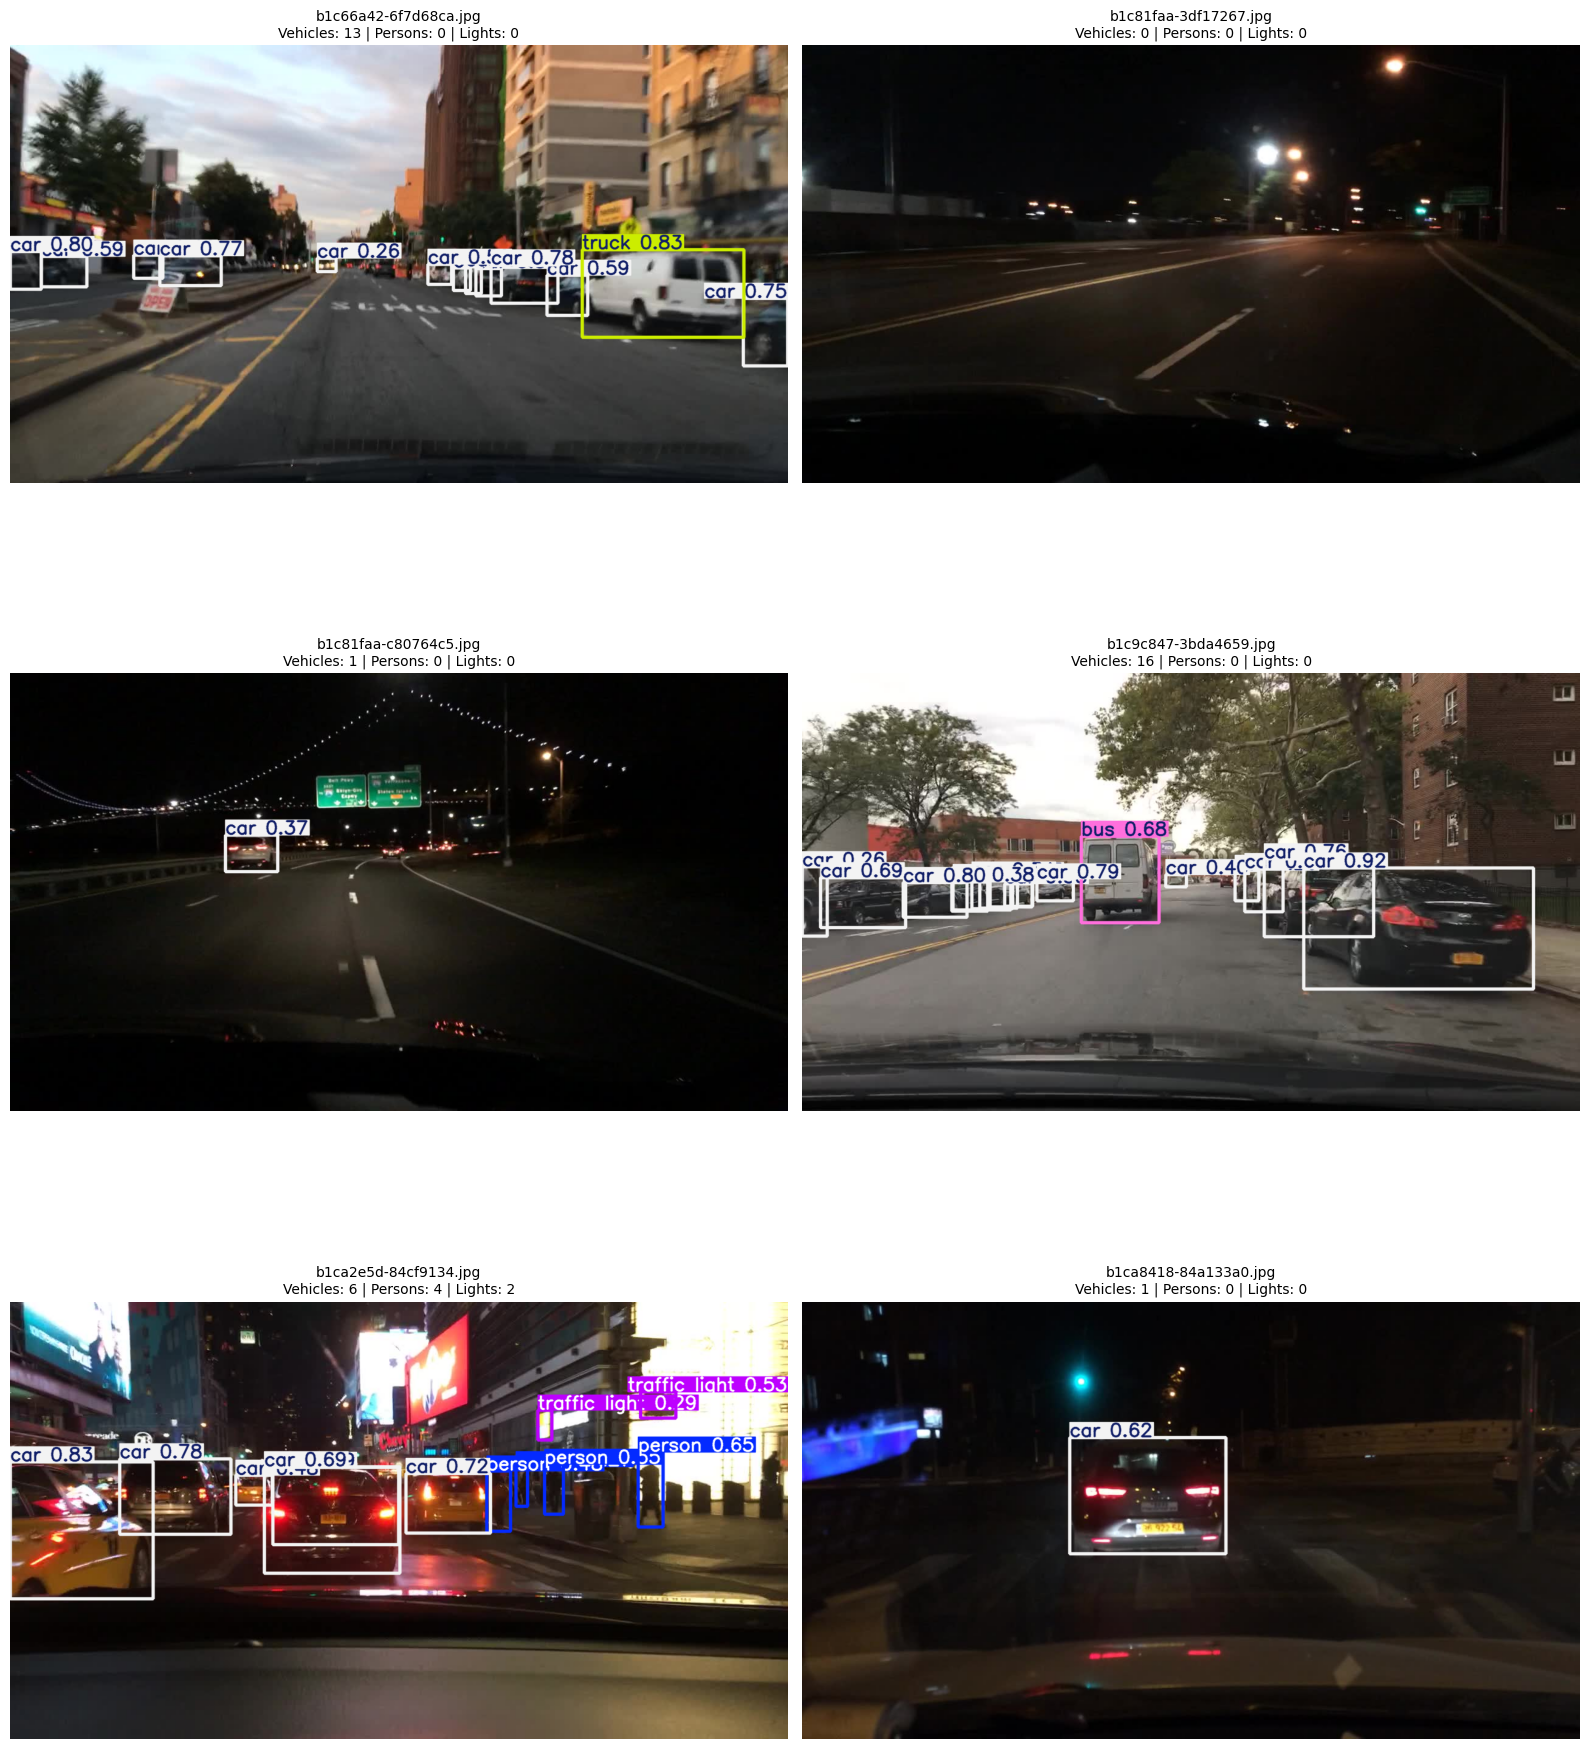

Visualization complete


In [28]:
#Visualize the first 6 images
fig, axes = plt.subplots(3, 2, figsize=(16,20))
axes = axes.ravel()

for i in range(6):
    result_data = results_data[i]
    annotated  = result_data['results'][0].plot()
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    axes[i].imshow(annotated_rgb)
    axes[i].set_title(
        f"{result_data['image']}\n"
        f"Vehicles: {result_data['vehicles']} | Persons: {result_data['persons']} | Lights: {result_data['traffic_lights']}",
        fontsize=10
    )
    axes[i].axis("off")
plt.tight_layout()
plt.show()
print("Visualization complete")

In [30]:
#Detection Statistics
total_vehicles = sum(d['vehicles'] for d in results_data)
total_persons = sum(d['persons'] for d in results_data)
total_lights = sum(d['traffic_lights'] for d in results_data)
total_all = sum(d['total_objects'] for d in results_data)

print(f"\nTotal Objects Detected: {total_all}")
print(f"  - Vehicles: {total_vehicles} ({total_vehicles/total_all*100:.1f}%)")
print(f"  - Persons: {total_persons} ({total_persons/total_all*100:.1f}%)")
print(f"  - Traffic Lights: {total_lights} ({total_lights/total_all*100:.1f}%)")
print(f"  - Other: {total_all - total_vehicles - total_persons - total_lights}")

print(f"\nAverage per image:")
print(f"  - Vehicles: {total_vehicles/20:.1f}")
print(f"  - Persons: {total_persons/20:.1f}")
print(f"  - Traffic Lights: {total_lights/20:.1f}")


Total Objects Detected: 146
  - Vehicles: 127 (87.0%)
  - Persons: 17 (11.6%)
  - Traffic Lights: 2 (1.4%)
  - Other: 0

Average per image:
  - Vehicles: 6.3
  - Persons: 0.8
  - Traffic Lights: 0.1


In [32]:
all_detected_classes = []
for d in results_data:
    all_detected_classes.extend(d['classes'])

class_counts = Counter(all_detected_classes)

print("Class Distribution")

for class_name, count in class_counts.most_common():
    print(f"{class_name}: {count}")

Class Distribution
car: 115
person: 17
truck: 10
bus: 2
traffic light: 2


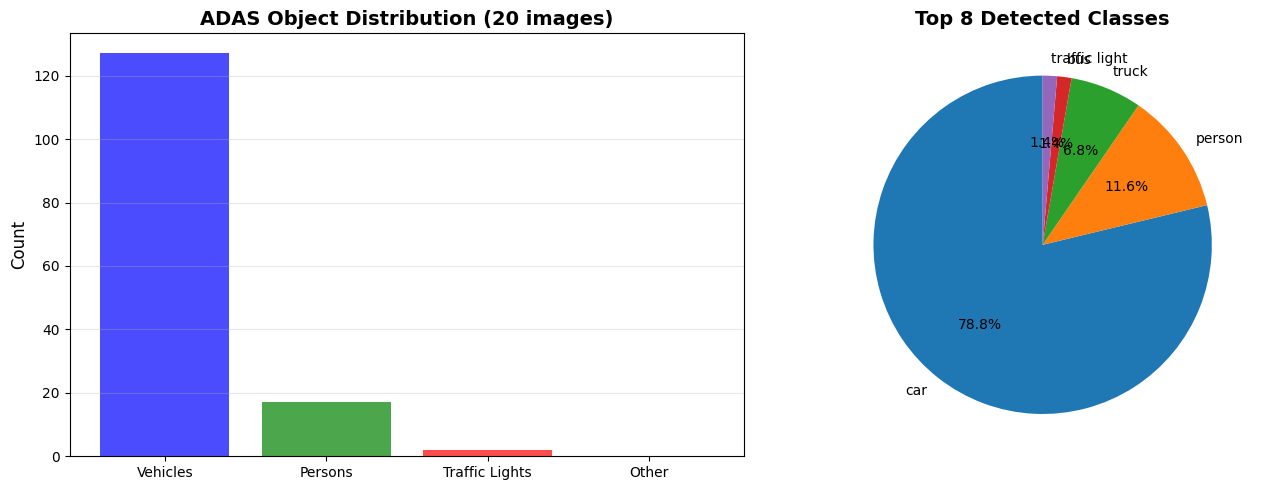

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of ADAS objects
ax = axes[0]
categories = ['Vehicles', 'Persons', 'Traffic Lights', 'Other']
counts = [total_vehicles, total_persons, total_lights, total_all - total_vehicles - total_persons - total_lights]
colors = ['blue', 'green', 'red', 'gray']

ax.bar(categories, counts, color=colors, alpha=0.7)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('ADAS Object Distribution (20 images)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Pie chart of top classes
ax = axes[1]
top_classes = class_counts.most_common(8)
labels = [c[0] for c in top_classes]
sizes = [c[1] for c in top_classes]

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Top 8 Detected Classes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [35]:
# Cell 10: Quality Analysis

print("Detection Quality Analysis")

# Find images with different scenarios
high_vehicle_images = [d for d in results_data if d['vehicles'] >= 5]
low_vehicle_images = [d for d in results_data if d['vehicles'] <= 2]
has_traffic_lights = [d for d in results_data if d['traffic_lights'] > 0]

print(f"\nImages with many vehicles (≥5): {len(high_vehicle_images)}")
print(f"Images with few vehicles (≤2): {len(low_vehicle_images)}")
print(f"Images with traffic lights: {len(has_traffic_lights)}")

DETECTION QUALITY ANALYSIS

Images with many vehicles (≥5): 13
Images with few vehicles (≤2): 5
Images with traffic lights: 1
